In [1]:
import folium
import branca
import numpy as np
import pandas as pd
from MoviaBusDataset import MoviaBusDataset
import matplotlib.pyplot as plt

In [2]:
prev_timesteps = 0
prediction_steps = 0

train = MoviaBusDataset('../data/train', 
                        interpolation=True,
                        max_future_time_steps=prediction_steps,
                        timeofday=True)
test = MoviaBusDataset('../data/test', 
                       interpolation=True,
                       max_future_time_steps=prediction_steps,
                       timeofday=True)
train = pd.concat(train.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})
test = pd.concat(test.dataframes,sort=False).unstack().reset_index().rename(columns={0:"Speed"})

train_all = train.pivot(index='Time', columns='LinkRef',values='Speed').groupby(['TimeOfDay']).mean()

test_org = test.pivot(index='Time', columns='LinkRef',values='Speed')

n_testdays = 5
n_measure = int(len(test_org)/n_testdays)

testday1 = test_org[0*n_measure:1*n_measure].groupby(['TimeOfDay']).mean()
testday2 = test_org[1*n_measure:2*n_measure].groupby(['TimeOfDay']).mean()
testday3 = test_org[2*n_measure:3*n_measure].groupby(['TimeOfDay']).mean()
testday4 = test_org[3*n_measure:4*n_measure].groupby(['TimeOfDay']).mean()
testday5 = test_org[4*n_measure:5*n_measure].groupby(['TimeOfDay']).mean()

test_all = test_org.groupby(['TimeOfDay']).mean()#This is the mean for all the test days

In [3]:
train2 = train.pivot(index='Time', columns='LinkRef',values='Speed')
train3 = train2.groupby(['TimeOfDay']).mean()
#train3.head()

In [4]:
test2 = test.pivot(index='Time', columns='LinkRef',values='Speed')
test3 = test2.groupby(['TimeOfDay']).mean()
#test3.head(). This is the mean for all the test days and hence the wrong data 

In [5]:
testday1 = test2[0:193].groupby(['TimeOfDay']).mean()
testday2 = test2[193:386].groupby(['TimeOfDay']).mean()
testday3 = test2[386:579].groupby(['TimeOfDay']).mean()
testday4 = test2[579:772].groupby(['TimeOfDay']).mean()
testday5 = test2[772:965].groupby(['TimeOfDay']).mean()

In [6]:
RMSE1 = np.sqrt(((testday1-train_all)**2).mean().mean())
RMSE2 = np.sqrt(((testday2-train_all)**2).mean().mean())
RMSE3 = np.sqrt(((testday3-train_all)**2).mean().mean())
RMSE4 = np.sqrt(((testday4-train_all)**2).mean().mean())
RMSE5 = np.sqrt(((testday5-train_all)**2).mean().mean())

print('Root Mean Square Error DAY1: ',RMSE1)
print('Root Mean Square Error DAY2: ',RMSE2)
print('Root Mean Square Error DAY3: ',RMSE3)
print('Root Mean Square Error DAY4: ',RMSE4)
print('Root Mean Square Error DAY5: ',RMSE5)

print('\nMean RMSE of all days: ',sum([RMSE1,RMSE2,RMSE3,RMSE4,RMSE5])/5)

MAE1 = abs(testday1-train_all).mean().mean()
MAE2 = abs(testday2-train_all).mean().mean()
MAE3 = abs(testday3-train_all).mean().mean()
MAE4 = abs(testday4-train_all).mean().mean()
MAE5 = abs(testday5-train_all).mean().mean()

print('\nMean Absolute Error DAY1: ',MAE1)
print('Mean Absolute Error DAY2: ',MAE2)
print('Mean Absolute Error DAY3: ',MAE3)
print('Mean Absolute Error DAY4: ',MAE4)
print('Mean Absolute Error DAY5: ',MAE5)

print('\nMean MAE of all days: ',sum([MAE1,MAE2,MAE3,MAE4,MAE5])/5)


MAPE1 = (abs(testday1-train_all)/abs(testday1)).mean().mean()*100
MAPE2 = (abs(testday2-train_all)/abs(testday2)).mean().mean()*100
MAPE3 = (abs(testday3-train_all)/abs(testday3)).mean().mean()*100
MAPE4 = (abs(testday4-train_all)/abs(testday4)).mean().mean()*100
MAPE5 = (abs(testday5-train_all)/abs(testday5)).mean().mean()*100

print('\nMean Absolute Procentage Error DAY1: ',MAPE1)
print('Mean Absolute Procentage Error DAY2: ',MAPE2)
print('Mean Absolute Procentage Error DAY3: ',MAPE3)
print('Mean Absolute Procentage Error DAY4: ',MAPE4)
print('Mean Absolute Procentage Error DAY5: ',MAPE5)

print('\nMean MAPE of all days: ',sum([MAPE1,MAPE2,MAPE3,MAPE4,MAPE5])/5)


#Dette er for gennemsnitlig hastigheder for alle testdage 
#MAE_all = abs(test3-train3).mean().mean()
#print('Mean absolute Error for mean of all days: ',MAE_all)

#RMSE for gennemsnitlig hastighed for alle testdage. Heller ikke brugbart 
#RMSE_all = np.sqrt(((test3-train3)**2).mean().mean())
#print('Root Mean Square Error for mean of all days: ',RMSE_all)

Root Mean Square Error DAY1:  2.2367059406593275
Root Mean Square Error DAY2:  2.3041221855077243
Root Mean Square Error DAY3:  2.246106211126054
Root Mean Square Error DAY4:  2.2889956589321416
Root Mean Square Error DAY5:  2.160281357723696

Mean RMSE of all days:  2.2472422707897888

Mean Absolute Error DAY1:  1.6411786164637372
Mean Absolute Error DAY2:  1.6967191026493602
Mean Absolute Error DAY3:  1.6554998773937288
Mean Absolute Error DAY4:  1.683933097968805
Mean Absolute Error DAY5:  1.5973326779978

Mean MAE of all days:  1.6549326744946864

Mean Absolute Procentage Error DAY1:  inf
Mean Absolute Procentage Error DAY2:  inf
Mean Absolute Procentage Error DAY3:  inf
Mean Absolute Procentage Error DAY4:  69.93929036038357
Mean Absolute Procentage Error DAY5:  inf

Mean MAPE of all days:  inf


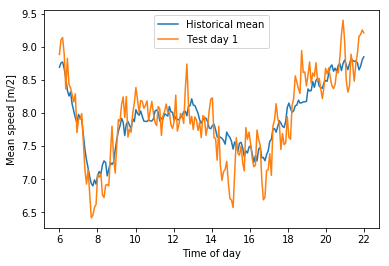

In [7]:
def plot_mean_speed(traindata,testdata,time_index,test_legend):
    plt.figure()
    plt.plot(time_index,traindata)
    plt.plot(time_index,testdata)
    plt.legend(['Historical mean',test_legend])
    plt.xlabel('Time of day')
    plt.ylabel('Mean speed [m/2]')
    
def newTime(data):
    newtime = [6+(22-6)/(len(data)-1)*i for i in range(0,len(data))]       
    #test3.index = [6+(22-6)/192*i for i in range(0,193)]
    return newtime

time_index = newTime(train_all)

#Plotting the mean of the different test days
plot_mean_speed(train_all.mean(1),testday1.mean(1),time_index,'Test day 1')
#plot_mean_speed(train_all.mean(1),testday2.mean(1),time_index,'Test day 2')
#plot_mean_speed(train_all.mean(1),testday3.mean(1),time_index,'Test day 3')
#plot_mean_speed(train_all.mean(1),testday4.mean(1),time_index,'Test day 4')
#plot_mean_speed(train_all.mean(1),testday5.mean(1),time_index,'Test day 5')


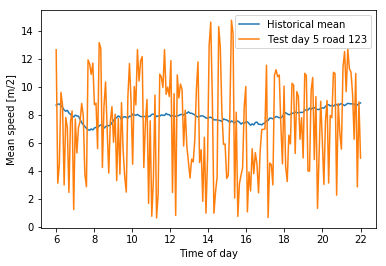

In [8]:
#Plotting a specific road for a specific test day
road = 123
plot_mean_speed(train_all.mean(1),testday2.values[road],time_index,'Test day 5 road %d' %road)

# Find high risk roads with STD and speed diference for each measurement of each road

In [71]:
test_org = test.pivot(index='Time', columns='LinkRef',values='Speed')

# Find the roads who has a high risk
link_ref_std=[] #This is the std of a road 
speed_diff=[]
for i in range(len(train_sort.values[0])-1):
    link_ref_std.append(np.std(train_sort.values[:,i]))   
for i in range(len(train_sort.values[0])-1):
    speed_diff.append(abs(train_sort.values[:,i+1]-train_sort.values[:,i]).mean())
     
std_link_ref_std = np.std(link_ref_std)
std_speed_diff = np.std(speed_diff)
print('STD of the std of each road: ', std_link_ref_std)
print('STD of the speed diff of each road: ', std_speed_diff)

highrisk_std = [i for i in link_ref_std if i >= 2*std_link_ref_std+np.mean(link_ref_std)] 
highrisk_speed = [i for i in speed_diff if i >= 2*std_speed_diff+np.mean(speed_diff)]
print('\nNumber of High Risk roads, STD: ', len(highrisk_std))
print('Number of High Risk roads, Speed Diff: ', len(highrisk_speed))

highrisk_std_index= []
highrisk_speed_index = []
for i in range(len(highrisk_std)):
    highrisk_std_index.append(link_ref_std.index(highrisk_std[i]))
for i in range(len(highrisk_speed)):
    highrisk_speed_index.append(speed_diff.index(highrisk_speed[i]))
print('\nHigh Risk road indicies, STD: ', highrisk_std_index)
print('High Risk road indicies, Speed Diff: ',highrisk_speed_index)

STD of the std of each road:  0.6514137341355518
STD of the speed diff of each road:  1.4236143105490855

Number of High Risk roads, STD:  6
Number of High Risk roads, Speed Diff:  8

High Risk road indicies, STD:  [5, 83, 124, 164, 173, 184]
High Risk road indicies, Speed Diff:  [44, 54, 59, 64, 95, 101, 111, 136]


<IPython.core.display.Javascript object>


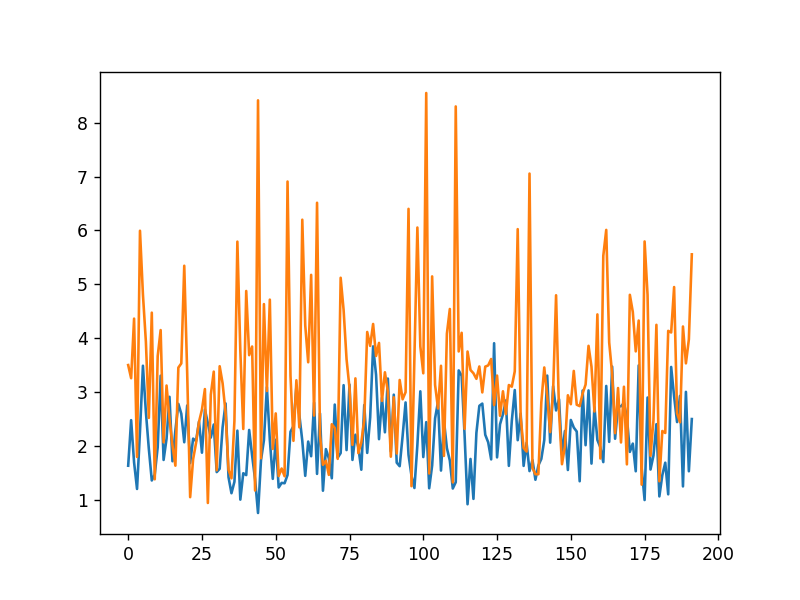

In [79]:
%matplotlib notebook
plt.plot(link_ref_std)
plt.plot(speed_diff)

# Visualize road segment

#### Choose between array of highrisk roads or just all roads 

In [81]:
train_all2 = train_all
linkrefs = train.groupby(['LinkRef']).mean()
linkrefs = [linkref.split(':') for linkref in  linkrefs.index[0:-1].tolist()]
wayID = [linkrefs[i].pop(0) for i in range(len(linkrefs))]
train_all2.columns = wayID

#Plot specific roads or plot all of them 
one_wayID = 1
#the_wayID = train_all2.columns[highrisk_std_index]#'25912893'
the_wayID = train_all2.columns[highrisk_speed_index]#'25912893'

#Create two colormaps, one for the mean speed and one for the number of meassurements
cm_mean = branca.colormap.linear.YlOrRd_04.scale(train_all2.values.min(),train_all2.values.max())

#Create a map object in valby
m = folium.Map(location=[55.66,12.515], zoom_start=15)

#Define style function, that change the color depending on the value of the mean speed
def style_trafic_mean(feature):
    wayid = feature['properties']['WayId']
    if one_wayID:
        if str(wayid) in the_wayID:
            val = train_all2[str(wayid)].mean()
            if np.size(val) > 1:
                val = val.mean()
            return {
                    'fillOpacity': 1,
                    'weight': 20,
                    'color':cm_mean(val)
            }
        else:
            val = 0
            return {
                    'fillOpacity': 0,
                    'weight': 0,
                    'color':0
            }
    else:
        if str(wayid) in wayID:
            val = train_all2[str(wayid)].mean()
            if np.size(val) > 1:
                val = val.mean()
            return {
                    'fillOpacity': 0.5,
                    'weight': 10,
                    'color':cm_mean(val)
            }
        else:
            val = 0
            return {
                    'fillOpacity': 0,
                    'weight': 0,
                    'color':0
            }
        
#Add the geojson with colors
g=folium.GeoJson('../data/road_network.geojson',name='mean speed', style_function=style_trafic_mean)
folium.GeoJsonTooltip(['WayId']).add_to(g)
g.add_to(m)
#This is a hack to show a colorbar, and also include all the streets
m.choropleth(geo_data='../data/road_network.geojson'
             , data=train_all2.mean(), columns=['WayID']
             , key_on='feature.properties.WayId'
             , fill_color='YlOrRd'
             , name='Streets'
             , legend_name='Mean speed [m/s]')
#Add a control layer to our map
folium.LayerControl().add_to(m)

#Show the resulting map
m

<IPython.core.display.Javascript object>


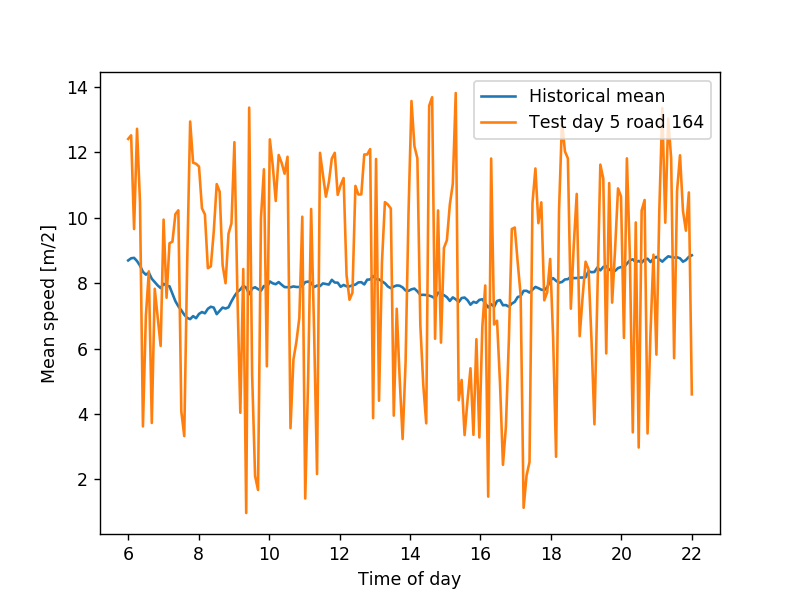

In [84]:
road = highrisk_std_index[3]
plot_mean_speed(train_all.mean(1),testday2.values[road],time_index,'Test day 5 road %d' %road)